The forcing function, $\zeta$ is approximated using Random Fourier Features so that

\begin{equation}
\zeta(t)\sim \sum_{i=1}^{M}\phi_i(t)z_i
\end{equation}

Then the derivative of $\zeta$ w.r.t the GP lengthscale, $l$, is 

\begin{equation}
\frac{\delta \zeta}{\delta l}  \sim \sum_{i=1}^{M}\left(\frac{\delta\phi_i}{\delta l}(t)z_i+\phi_i(t)\frac{\delta z_i}{\delta l}\right)

\end{equation}

This requires us to know the derivatives of $\phi_i$ and $z$ with respect to $l$. Recall that $\phi_i$ is defined
\begin{equation}
\phi_i(x) = \sqrt{\frac{2\tau^2}{M}} \cos( \frac{1}{l}w_i^\top x+b_i)\label{eqn:rff}
\end{equation}
so that 
\begin{equation}
\frac{\delta\phi_i}{\delta l}(x) = w_i^\top x\frac{1}{l}\sqrt{\frac{2\tau^2}{M}} \cos( \frac{1}{l}w_i^\top x+b_i)
\end{equation}

The derivative of $\mathbf{z}$ is a little more complicated, as the distributio over $\mathbf{z}$ is calculated using the adjoint method, and the true value is not known, as a surrogate, we use the mean calculated using the Adjoint method, $\mu_n$:
\begin{equation}
\mu_n = \Sigma_n (\frac{1}{\sigma^2}\Phi^\top z +\Sigma_0^{-1} \mu_0), \;\; \Sigma_n=\left(\frac{1}{\sigma^2}\Phi^\top \Phi + \Sigma_0^{-1}\right)^{-1}.\label{eqn:Bayes2}
\end{equation}
Then (assuming that the prior mean and covariance have no $l$ dependence)
\begin{equation}
\frac{\delta \mathbf{z}}{\delta l} = \frac{\delta \mu_n}{\delta l}= -\frac{1}{\sigma^4}\Sigma_n\left(\frac{\delta\Phi^\top}{\delta l}\Phi+\Phi^\top\frac{\delta\Phi}{\delta l}\right)\Sigma_n\Phi^\top\mathbf{y}+\Sigma_n\frac{1}{\sigma^2}\frac{\delta \Phi^\top}{\delta l}\mathbf{y}
\end{equation}
Where $\Phi$ is given by
\begin{equation}
\Phi=\begin{pmatrix} \langle v_1, \phi_1 \rangle & \ldots & \langle v_1, \phi_M \rangle\\
\vdots&&\vdots\\
\langle v_n, \phi_1 \rangle & \ldots & \langle v_n, \phi_M \rangle
\end{pmatrix}
\end{equation}
where $v_i$ is the solution to the adjoint for observation $y_i$ and has no $l$ dependence, so that

\begin{equation}
\frac{\delta\Phi}{\delta l}=\begin{pmatrix} \langle v_1, \frac{\delta\phi_1}{\delta l} \rangle & \ldots & \langle v_1, \frac{\delta\phi_M}{\delta l} \rangle\\
\vdots&&\vdots\\
\langle v_n, \frac{\delta\phi_1}{\delta l} \rangle & \ldots & \langle v_n, \frac{\delta\phi_M}{\delta l} \rangle
\end{pmatrix}
\end{equation}

In [2]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP
from advectionGP.models import AdjointSecondOrderODEModel as Model #Model module builds basic parts of the ODE problem, combines other classes into full model

'''To use other models in the class, such as the Advection Diffusion Reaction model, 
replace "AdjointSecondOrderODEModel" in the line above with "AdjointAdvectionDiffusionReaction" model
and adjust parameters as appropriate'''

from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model


#Plotting tools
import matplotlib.pyplot as plt

In [3]:
avg=0.01 # time that an observation is taken for
tlocL = np.linspace(0,9.9,20) # observation start times
X= np.zeros((len(tlocL),2)) # initiate X
# Build sensor locations
X[:,0] = tlocL #lower time
X[:,1] = X[:,0]+avg # upper time

In [4]:
avg=0.01 # time that an observation is taken for
tlocL2 = np.linspace(0,9.8,5) # observation start times
X2= np.zeros((len(tlocL2),2)) # initiate X
# Build sensor locations
X2[:,0] = tlocL2 #lower time
X2[:,1] = X2[:,0]+avg # upper time

In [5]:
tlocL

array([0.        , 0.52105263, 1.04210526, 1.56315789, 2.08421053,
       2.60526316, 3.12631579, 3.64736842, 4.16842105, 4.68947368,
       5.21052632, 5.73157895, 6.25263158, 6.77368421, 7.29473684,
       7.81578947, 8.33684211, 8.85789474, 9.37894737, 9.9       ])

In [6]:
tlocL2

array([0.  , 2.45, 4.9 , 7.35, 9.8 ])

In [7]:
sensors = FixedSensorModel(X,0) # establish sensor model arguments are sensor locations and spatial averaging (not applicable in 1D case so set to 0)

In [8]:
sensorsHeldOut=FixedSensorModel(X2,0)#

In [9]:
k_0 = -1 #Diffusion coefficient
u=0.8
eta=5
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0],[10])# edges of the grid - in units of time
kForward = EQ(0.6, 4.0) # generate EQ kernel arguments are lengthscale and variance
res = [500] # grid size for time

In [11]:
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kForward,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #initiate PDE model to build concentration

dt,dt2,Nt = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
sourceGT=m.computeSourceFromPhi(z)# Compute ground truth source by approximating GP
#sourceGT = np.ones(m.resolution)  # Example constant source
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs ODE forward model
yTrain= m.computeObservations(addNoise='TRUE') # Compute observations with noise uses m.sensormodel for observation locations
m.sensormodel=sensorsHeldOut
yTest=m.computeObservations(addNoise='TRUE')

In [12]:
#%%timeit
N_feat =200 #Number of features used to infer the source
kInverse = EQ(.6, 4) # Initiate kernel for inverse problem
x = np.array([u,eta,k_0])#+np.random.normal(0,0.1,3)
#x=[1,1,-1]
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,k_0=x[2],u=x[0],eta=x[1]) #Initiate new model for inference
mInfer.computeModelRegressors() # Compute regressor matrix 
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source

Calculating Adjoints...
19/20 
Calculating Phis...
199/200 


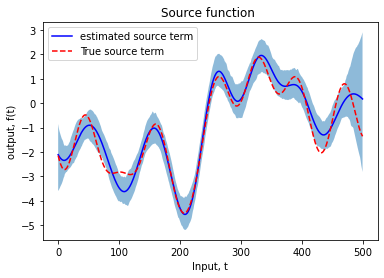

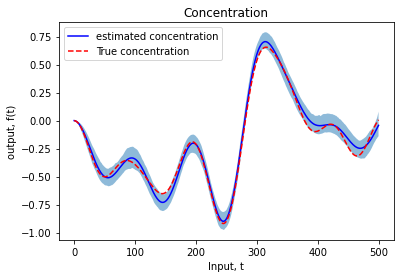

In [13]:
source_samples = []
conc_samples=[]    
for z_samp in np.random.multivariate_normal(meanZ, covZ,200):
    source_samples.append(mInfer.computeSourceFromPhi(z_samp))
    conc_samples.append(mInfer.computeConcentration(mInfer.computeSourceFromPhi(z_samp)))
source_samples=np.array(source_samples)
conc_samples=np.array(conc_samples)

source_lower_ci = np.percentile(source_samples,2.5,0)
source_upper_ci = np.percentile(source_samples,97.5,0)
source_mean = np.percentile(source_samples,50,0)

conc_lower_ci = np.percentile(conc_samples,2.5,0)
conc_upper_ci = np.percentile(conc_samples,97.5,0)
conc_mean = np.percentile(conc_samples,50,0)

xtest=np.arange(Nt)

#plt.figure(figsize=(15, 10))

plt.plot(xtest,sourceInfer,'b-')
plt.plot(xtest,sourceGT,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,source_lower_ci,source_upper_ci,alpha=0.5)
plt.legend(labels=["estimated source term","True source term"])
plt.title("Source function ")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
#plt.ylim([-5,5])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

#plt.figure(figsize=(15, 10))

plt.plot(xtest,concInfer,'b-')
plt.plot(xtest,concTrain,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,conc_lower_ci,conc_upper_ci,alpha=0.5)
plt.legend(labels=["estimated concentration","True concentration"])
plt.title("Concentration")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
#plt.ylim([-5,5])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

In [14]:
def dcost(obs,tloc,conc,model):
    
    dc=np.zeros(model.resolution) #initialise cost derivative
    M=len(obs) # number of observations
    dc[model.getGridCoord(tloc)] = 2*(conc[model.getGridCoord(tloc)]-obs)*(1/M) # cost derivative approximated with step functions
    
    return dc

def cost(obs,tloc,conc,model):
    
    c=np.zeros(model.resolution) # initialise cost
    M=len(obs) # number of observations
    c[model.getGridCoord(tloc)] = ((conc[model.getGridCoord(tloc)]-obs)**2)*(1/M) # cost approximated with hill function
    
    return c

In [15]:
def computeGradientAdjoint(dcost,model):
    """
    Runs the backward second order ODE (adjoint problem)
    Gets called for an observation instance (H).
    (v is the result of the adjoint operation)
    """
    dt,dt2,Nt = model.getGridStepSize()
    k_0=model.k_0
    u=model.u
    eta=model.eta
    v=np.zeros(((model.resolution)))
    
    #Boundary conditions
    v[Nt-1] = 0
    v[Nt-2] = (1.0/(1-(u*dt/(2*k_0))))*(-dcost[Nt-1]*(dt2)- v[Nt-1]-u*dt*v[Nt-1]/(k_0*2.0)+ 2*v[Nt-1]+(eta/k_0)*(dt2)*v[Nt-1])

    # Calculation away from boundary
    for i in reversed(range(1,Nt-1)):
        #i=Nt-j-2
        v[i-1]=(1.0/(1-(u*dt/(2*k_0))))*(-dcost[i]*(dt2)- v[i+1]-u*dt*v[i+1]/(k_0*2.0)+ 2*v[i]+(eta/k_0)*(dt2)*v[i])

    return v

In [16]:
def getdPhiDerivative1D(model,coords):
    """
    Generates a (N_feat,Nt) matrix of basis vectors using features from generateFeatures 
    Arguments:
        coords: map of all (t) points in the grid
    """
    assert model.kernel.W is not None, "Need to call generateFeatures before computing phi."
    norm = 1./np.sqrt(model.kernel.N_feat)

    #We assume that we are using the e^-(1/2 * x^2/l^2) definition of the EQ kernel,
    #(in Mauricio's definition he doesn't use the 1/2 factor - but that's less standard).
    #c=np.sqrt(2.0)/(self.l2)
    c=1/(model.kernel.l2)
    for w,b in zip(model.kernel.W,model.kernel.b):
        dphi=w*np.array(coords)*(c**2)*norm*np.sqrt(2*model.kernel.sigma2)*np.sin((c*w*np.array(coords))+b)
        yield dphi

In [17]:
def computeModelRegressorsDerivative(self):
    """
    Computes the regressor matrix X, using getHs1D from the senor model and getPhi1D from the kernel.
    X here is used to infer the distribution of z (and hence the source)
    """
    dt,dt2,Nt = self.getGridStepSize()
    dX = np.zeros([self.N_feat,len(self.sensormodel.obsLocs)])

    adjs = []
    print("Calculating Adjoints...")
    for j,H in enumerate(self.sensormodel.getHs1D(self)):
        print("%d/%d \r" % (j,len(self.sensormodel.obsLocs)),end="")
        adjs.append(self.computeAdjoint(H))
    print("");
    #this will run out of memory...
    print("Calculating Phis...")
    for i,phi in enumerate(getdPhiDerivative1D(self,self.coords)):
        print("%d/%d \r" % (i,len(self.kernel.W)),end="")
        for j,adj in enumerate(adjs):


            dX[i,j] = np.sum(np.array(phi)*np.array(adj[:,None])*dt)

    print("");
    #phi * v, --> scale
    return dX

In [18]:
def computeZDerivative(self,y):
        """
        Computes the z distribution using the regressor matrix and a vector of observations
        Arguments:
            y: a vector of observations (either generated using compute observations of given by the user in the real data case)
        """
        #uses self.X and observations y.
        dX = computeModelRegressorsDerivative(self)
        X = self.computeModelRegressors()
        SS = (1./(self.noiseSD**2))*(X@X.T) +np.eye(self.N_feat)
        SSinv= np.linalg.inv(SS)
        dZ= -(1./(self.noiseSD**2))*SSinv@((1./(self.noiseSD**2))*(dX@X.T + X@dX.T))@(SSinv @self.X@y)+(1./(self.noiseSD**2))*SSinv@dX@y
        
         #sum_cc.flatten())
        return dZ

In [19]:
dZ=computeZDerivative(mInfer,yTrain)
dZ.shape

Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 


(200,)

In [20]:
def computeSourceDerivative(model,z,y,coords=None):
        """
        uses getPhi from the kernel and a given z vector to generate a source function     
        set coords to a matrix: (3 x Grid Resolution), e.g. (3, 300, 80, 80)
                e.g. coords=np.asarray(np.meshgrid(tt,xx,yy,indexing='ij'))
        
        """
        if coords is None: coords = model.coords
        resolution = np.array(coords.shape[0:])
        dsource = np.zeros(resolution) 
        dZ = computeZDerivative(model,y)
        for i, (phi,dphi) in enumerate(zip(model.kernel.getPhi1D(model.coords),getdPhiDerivative1D(model,model.coords))):
            dsource += dphi*z[i] + phi*dZ[i]
        
        return dsource

In [21]:
def d_mLLambda(l,model,yTrain,yTest,tTrain,tTest):
    
    # change parameters in model object
    
    model.sensormodel=sensors
    
    model.kernel.l2=l 
    
    model.computeModelRegressors() # Compute regressor matrix 
    meanZ, covZ = model.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
    source= model.computeSourceFromPhi(meanZ)
    # calculate useful values
    dt,dt2,Nt = model.getGridStepSize()
    # compute concentration with new parameters
    conc=model.computeConcentration(source)
    
    model.sensormodel=sensorsHeldOut
    #compute cost derivative and cost
    dc=dcost(yTest,tTest,conc,model)
    c=cost(yTest,tTest,conc,model)
    
    # derivative of h operator with respect to parameters
    model.sensormodel=sensors
    dmH=-computeSourceDerivative(model,meanZ,yTrain)/model.k_0

    # compute and calculate Lagrangian derivative integral
    integrand = -computeGradientAdjoint(dc,model)*dmH.T
    L_m = np.trapz(integrand,dx=dt)
    #model.sensormodel=sensors
    #L_m = np.sum(integrand)*dt #alternate calculation using naive numerical integration
    return L_m, dc,c

In [22]:
reps=5000

# initialise outputs
p=np.zeros((1,reps)) # parameters
p2=np.zeros((1,reps)) # parameters
d=np.zeros((1,reps-1)) # derivative
dTest=np.zeros((1,reps-1)) # forward difference derivative approximation
dTest2=np.zeros((1,reps-1)) # central difference derivative approximation
Fc=np.zeros((1,reps-1)) # integrated cost function
p[:,0]=1 # first parameter value]
p2[:,0]=1 # first parameter value
eps2=1e-6
for i in range(reps-1):
    l = p[:,i]
    l2 = p2[:,i]
    dmL, dc,c=d_mLLambda(l,mInfer,yTrain,yTest,tlocL,tlocL2)
    d[:,i]=dmL
    p[:,i+1]=p[:,i]-1*dmL
    
    Fc[:,i] = sum(c)*dt
    #dmL2, dc2,c2=d_mLLambda(l2+eps2,mInfer,yTrain,tlocL)
    #dmL3, dc3,c3=d_mLLambda(l2,mInfer,yTrain,tlocL)
    dmL4, dc4,c4=d_mLLambda(l+eps2,mInfer,yTrain,yTest,tlocL,tlocL2)
    #dmL3, dc3,c3=d_mL(k_01,u1,eta1+eps2,mInfer,yTrain,tlocL,sourceInfer)
    #dmL4, dc4,c4=d_mL(k_01+eps2,u1,eta1,mInfer,yTrain,tlocL,sourceInfer)
    # dmL5, dc5,c5=d_mL(dmH,k_01,u1-eps2,eta1,m,yTrain,tlocL,sourceInfer)
    #dmL6, dc6,c6=d_mL(dmH,k_01,u1,eta1-eps2,m,yTrain,tlocL,sourceInfer)
    # dmL7, dc7,c7=d_mL(dmH,k_01-eps2,u1,eta1,m,yTrain,tlocL,sourceInfer)
    
    #dTest[:,i:i+1] = (np.array((sum((c2))*dt-sum((c5))*dt,sum((c3))*dt-sum((c6))*dt,sum((c4))*dt-sum((c7))*dt)))/(2*eps2)
    #dTest2[:,i:i+1] = ((sum(c2)*dt)-(sum(c3)*dt))/(eps2)
    dTest[:,i:i+1] = ((sum(c4)*dt)-(sum(c)*dt))/(eps2)
    p2[:,i+1]=p2[:,i]-1*dTest[:,i:i+1] 

Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculati

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculati

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculati

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculati

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating

Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculati

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculati

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculati

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculati

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculati

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculati

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


In [23]:
yTest

array([ 0.05372989, -0.5147604 , -0.98649282,  0.15682966, -0.09092251])

In [24]:
((sum(c4)*dt)-(sum(c)*dt))/(eps2)

array([6.00180306e-07])

In [25]:
np.sum(c4)

0.008398436346095718

In [26]:
 np.mean((dTest-d)**2)

3.5917153716778697e-13

In [27]:
dmL4

array([1.612027e-08])

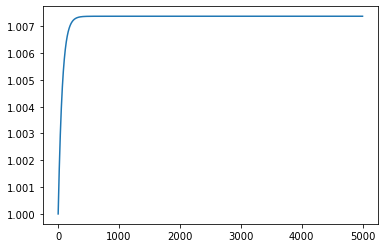

In [28]:
 plt.plot(p.T)

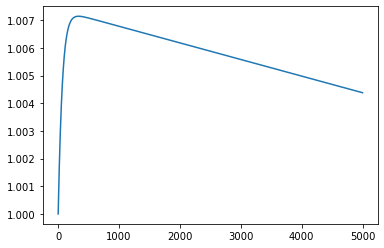

In [29]:
 plt.plot(p2.T)

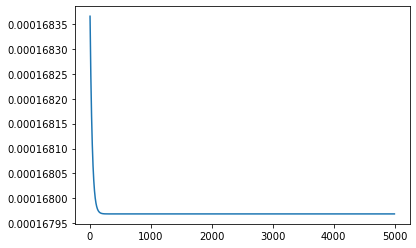

In [30]:
plt.plot(Fc.T)

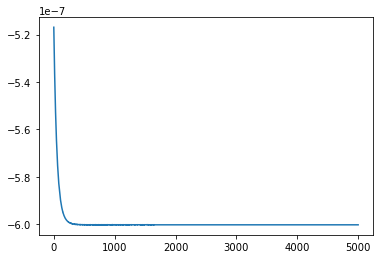

In [31]:
plt.plot((d.T-dTest.T))

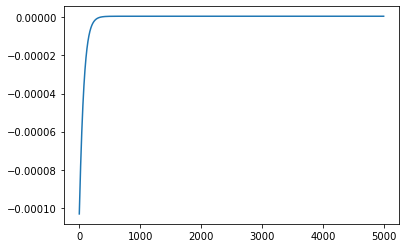

In [32]:
plt.plot(dTest.T)

In [33]:
Fc

array([[0.00016837, 0.00016836, 0.00016834, ..., 0.00016797, 0.00016797,
        0.00016797]])

In [34]:
d

array([[-1.03716186e-04, -1.02468872e-04, -1.01230620e-04, ...,
        -6.35071423e-17, -6.35071423e-17, -6.35071423e-17]])

In [35]:
dTest

array([[-1.03199280e-04, -1.01950366e-04, -1.00710541e-04, ...,
         6.00180306e-07,  6.00180306e-07,  6.00180306e-07]])

In [36]:
def FullCost(x,model,yTrain,yTest,tTrain,tTest):
    model.sensormodel=sensors
    model.kernel.l2=x
    dt,dt2,Nt = model.getGridStepSize()
    model.computeModelRegressors() # Compute regressor matrix 
    meanZ, covZ = model.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
    source= model.computeSourceFromPhi(meanZ)
    # compute concentration with new parameters
    conc=model.computeConcentration(source)
    model.sensormodel=sensorsHeldOut
    #compute cost derivative and cost
    dc=dcost(yTest,tTest,conc,model)
    c1=cost(yTest,tTest,conc,model)
    
    c = np.sum(c1)*dt
    
    return c

In [37]:
def FullDeriv(x,model,yTrain,yTest,tTrain,tTest):
    model.sensormodel=sensors
    model.kernel.l2=x 

    
    # calculate useful valyes
    dt,dt2,Nt = model.getGridStepSize()
    model.computeModelRegressors() # Compute regressor matrix 
    meanZ, covZ = model.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
    source= model.computeSourceFromPhi(meanZ)
    # compute concentration with new parameters
    conc=model.computeConcentration(source)
    model.sensormodel=sensorsHeldOut
    #compute cost derivative and cost
    dc=dcost(yTest,tTest,conc,model)
    c=cost(yTest,tTest,conc,model)
    
    # derivative of h operator with respect to parameters
    model.sensormodel=sensors
    dmH=-computeSourceDerivative(model,meanZ,yTrain)/model.k_0

    # compute and calculate Lagrangian derivative integral
    integrand = -computeGradientAdjoint(dc,model)*dmH.T
    L_m = np.trapz(integrand,dx=dt)
    #L_m = np.sum(integrand)*dt
    return L_m

In [38]:
fc = np.zeros(1000)
dc = np.zeros(1000)
x=np.linspace(0.1,1,1000)
for i in range(1000):
    fc[i] = FullCost(x[i],mInfer,yTrain,yTest,tlocL,tlocL2)
    dc[i] = FullDeriv(x[i],mInfer,yTrain,yTest,tlocL,tlocL2)

Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculati

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculati

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 


19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calc

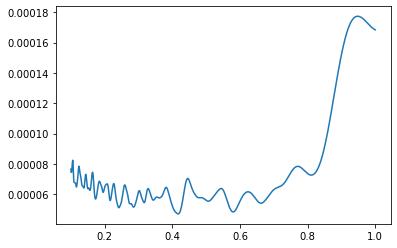

In [39]:
plt.plot(x[0:1000],fc[0:1000])

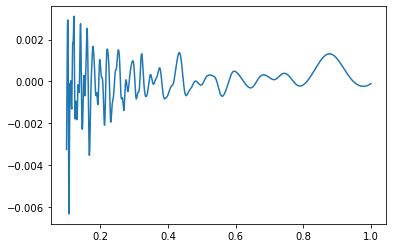

In [40]:
plt.plot(x,dc)

In [41]:
from scipy.optimize import minimize

In [42]:
x0=0.6
result = minimize(FullCost,x0, method='BFGS', jac=FullDeriv,args=(mInfer,yTrain,yTest,tlocL,tlocL2),options={'disp': True})#,tol=1e-8)

Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculating Phis...
199/200 
Calculating Adjoints...
19/20 
Calculati

In [43]:
result


      fun: 4.8380263577338274e-05
 hess_inv: array([[46.39247532]])
      jac: array([-9.63845165e-07])
  message: 'Optimization terminated successfully.'
     nfev: 8
      nit: 2
     njev: 8
   status: 0
  success: True
        x: array([0.57985565])